In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import cv2

import statsmodels.api as sm

%matplotlib inline

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import ndimage

In [3]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_094/func_0'

In [4]:
t0 = time()
save_file = os.path.join(directory, 'pca', 'scores_(spatial).npy')
pca_spatial = np.load(save_file)
save_file = os.path.join(directory, 'pca', 'loadings_(temporal).npy')
pca_loadings = np.load(save_file)
#pca_spatial.shape = (4554, -1)
#pca_spatial.shape = (4554, 128, 84, 49)
print('Duration: {}'.format(time()-t0))

Duration: 30.260717630386353


In [6]:
out = np.max(np.abs(pca_spatial[:100,...]),axis=-1)

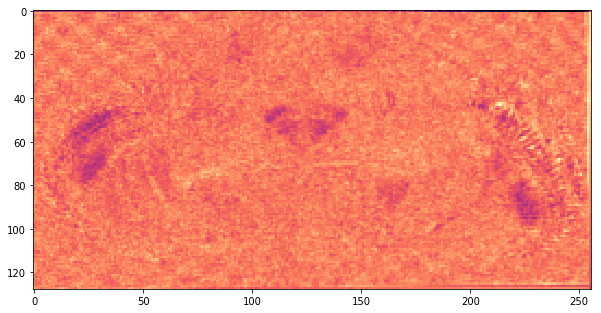

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(pca_spatial[9,:,:,20].T,cmap='magma')

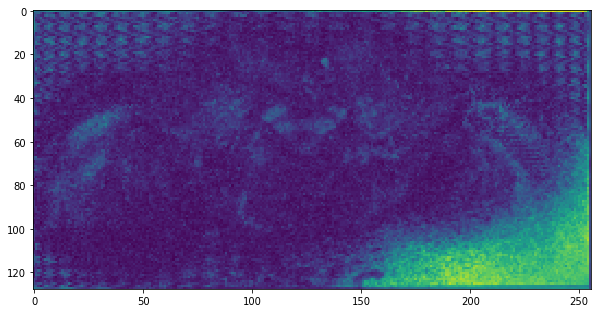

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(out[9,:,:].T)

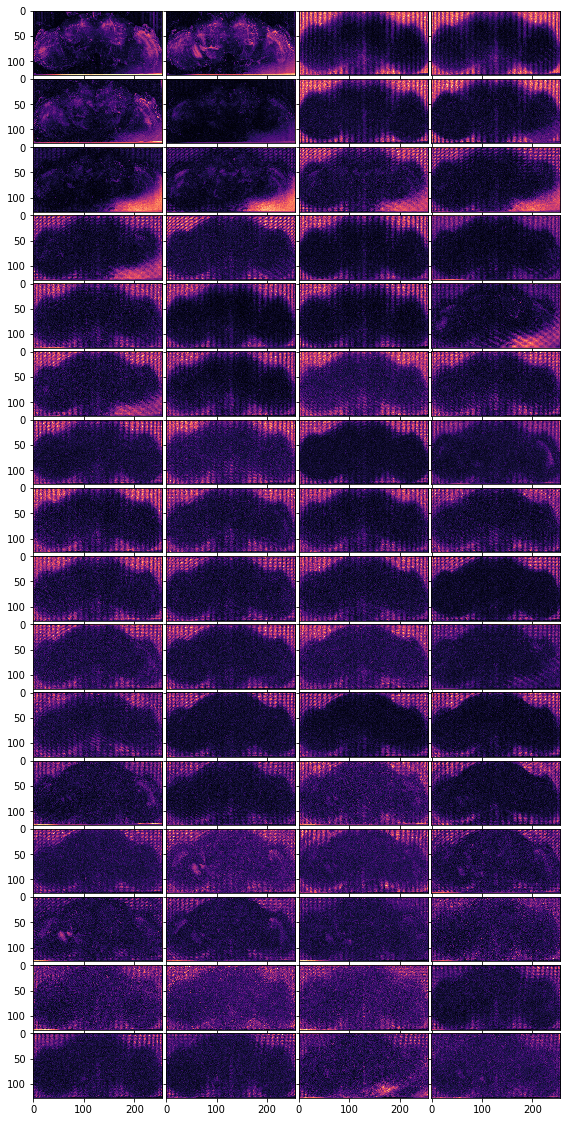

In [7]:
fig = plt.figure(figsize=(10,20))
grid = ImageGrid(fig, 111, nrows_ncols=(16, 4), axes_pad=.05)
for i in range(64):
    grid[i].imshow(out[i,:,:].T,cmap='magma')

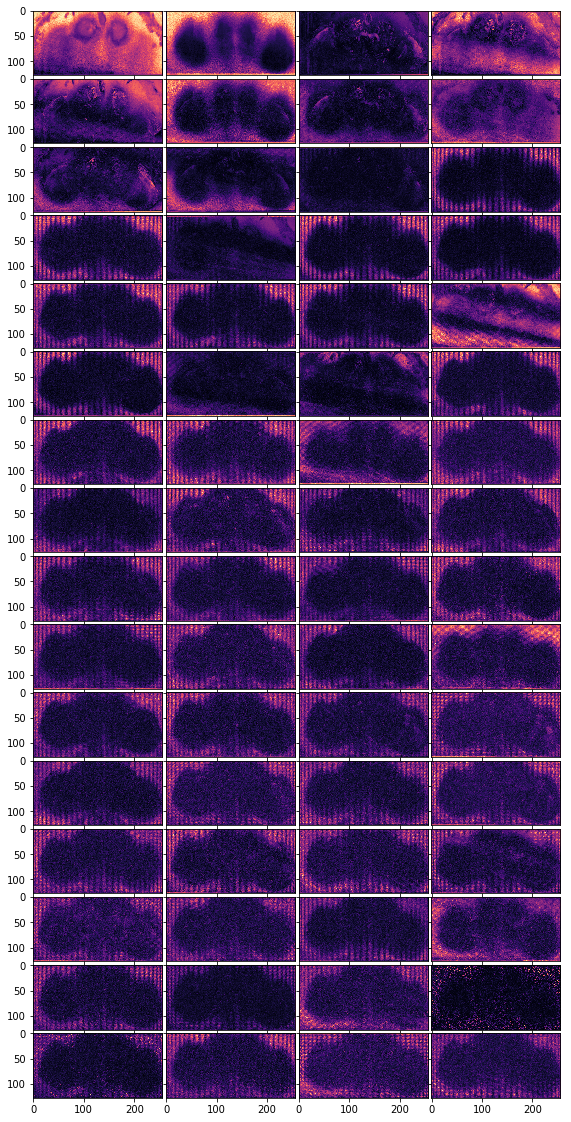

In [62]:
fig = plt.figure(figsize=(10,20))
grid = ImageGrid(fig, 111, nrows_ncols=(16, 4), axes_pad=.05)
for i in range(64):
    grid[i].imshow(out[i,:,:].T,cmap='magma')

In [28]:
pca_spatial.shape

(3384, 256, 128, 49)

In [ ]:
pca_spatial

In [41]:
out[0,:,:]

array([[0.00535961, 0.00536986, 0.00547318, ..., 0.00446394, 0.00437118,
        0.00407215],
       [0.00580754, 0.00610887, 0.00628249, ..., 0.00091055, 0.00099192,
        0.00157321],
       [0.00571233, 0.0063586 , 0.00611108, ..., 0.00082668, 0.00064749,
        0.00146427],
       ...,
       [0.00480725, 0.00511495, 0.00454661, ..., 0.00461694, 0.00474534,
        0.00325519],
       [0.00480511, 0.00519486, 0.00511219, ..., 0.00453678, 0.00454009,
        0.00324379],
       [0.00311358, 0.00350237, 0.00328239, ..., 0.0008145 , 0.00091828,
        0.00171184]], dtype=float32)

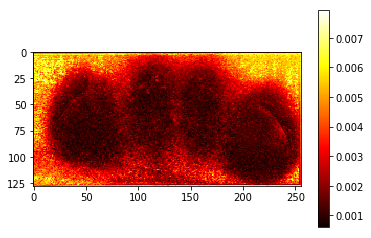

In [49]:
plt.imshow(out[5,:,:].T,cmap='hot')
plt.colorbar()

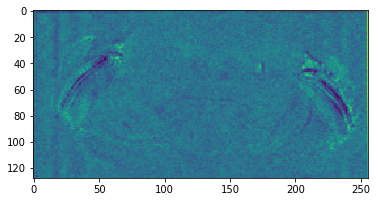

In [26]:
plt.imshow(pca_spatial[3,:,:,20].T)

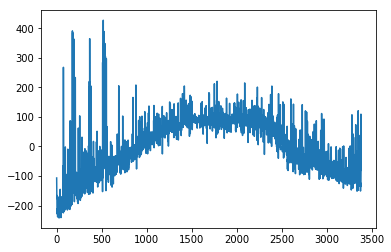

In [67]:
plt.plot(pca_loadings[:,3])

In [11]:
pca_loadings.shape

(3384, 3384)

In [17]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Failed. Extracting frame timestamps from bruker xml file.
Success.
load_timestamps done. Duration: 13.48 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.01 sec


In [18]:
def interp_fictrac(fictrac, fps, resolution, expt_len, timestamps):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    dx = np.asarray(fictrac['dRotLabX'])
    dy = np.asarray(fictrac['dRotLabY'])
    dz = np.asarray(fictrac['dRotLabZ'])
    dx = scipy.signal.savgol_filter(dx,25,3)
    dy = scipy.signal.savgol_filter(dy,25,3)
    dz = scipy.signal.savgol_filter(dz,25,3)
    fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    
    fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    fictrac_interp = fictrac_interp_temp(timestamps[:,25])

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

resolution = 10 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
fictrac_interp = interp_fictrac(fictrac, fps, resolution, expt_len, timestamps)
xnew = np.arange(0,expt_len,resolution)

In [19]:
Y_glm = fictrac_interp
models = []
for num_pcs in [10,100,1000,1001]:
    t0 = time()
    models.append({'num_pcs': num_pcs, 'model': LassoCV(), 'model_type': 'LassoLarsIC'})
    X_glm = pca_loadings[:,:num_pcs]
    models[-1]['model'].fit(X_glm, Y_glm)
    models[-1]['score'] = models[-1]['model'].score(X_glm, Y_glm)
    print('Num PCs: {}, Duration: {} sec'.format(num_pcs, time()-t0))

Num PCs: 10, Duration: 0.07570981979370117 sec
Num PCs: 100, Duration: 0.3221702575683594 sec
Num PCs: 1000, Duration: 8.89500880241394 sec
Num PCs: 1001, Duration: 9.108052253723145 sec


Text(0.5, 0.98, 'Regularization: LassoLarsIC(BIC)')

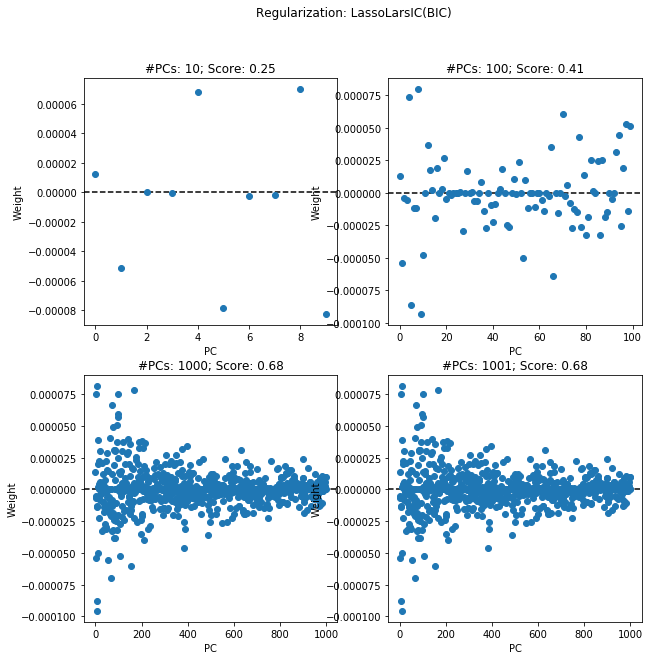

In [20]:
plt.figure(figsize=(10,10))

for i, model in enumerate(models):
    plt.subplot(2,2,i+1)
    plt.axhline(0,color='k',linestyle='--')
    plt.plot(model['model'].coef_,'o')
    plt.title ('#PCs: {}; Score: {:.2f}'.format(model['num_pcs'], model['score']))
    plt.ylabel('Weight')
    plt.xlabel('PC')
    
plt.suptitle('Regularization: LassoLarsIC(BIC)')

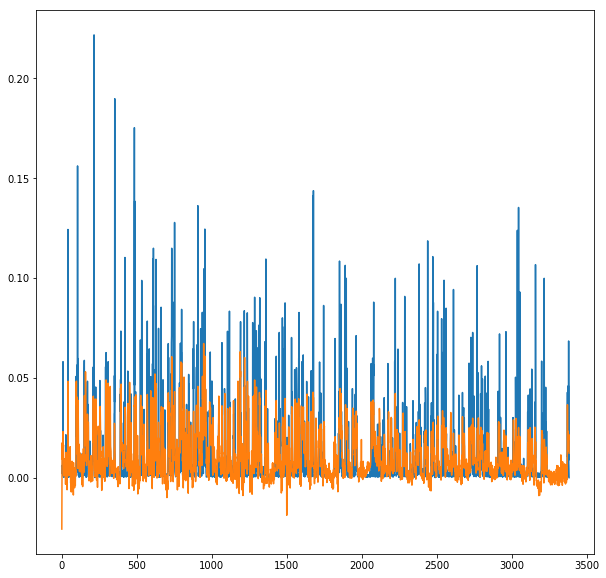

In [21]:
plt.figure(figsize=(10,10))
plt.plot(Y_glm)
#plt.plot(models[0]['model'].predict(pca_loadings[:,:10]))
plt.plot(models[1]['model'].predict(pca_loadings[:,:100]))
#plt.xlim(0,1400)